In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte


## Now why did exact do that when gamma = 0

In [ ]:

def main():
    # Initialize the simulation parameters
    N = 2
    gamma_L= 0.5
    gamma_R = 0

    eps = 1
    mu_L= 1
    mu_R= 1.1
    T_L = 3
    T_R= 1
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1
  
    time = 50.0
    dt = 0.1
    nt = int(time/dt)
    #exact_diag_ham= build_exact_diag_hamiltonian(N,J, eps)
   # print("Exact Ham", exact_diag_ham)

   
    ham_real, ham_imag = hamiltonian_generation(N, eps, gamma_L, gamma_R, F_L, F_R,J)
    print("Ham imag", ham_imag)
    print("Ham real", ham_real)

    exact_diag_results, time_points = [],[]

    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real,N)
    #exact_diag_results, time_points = perform_exact_diag(gamma_L, gamma_R, F_L, F_R, dt, nt, exact_diag_init_state,exact_diag_ham,N,eps)

    print("VQTE initial state", vqte_init_state)
    print("Exact initial state:",exact_diag_init_state)
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
    
    # # Output results
    output_results(vqte_results, exact_diag_results, time, nt, time_points)
    print(vqte_results[-1][-1])

Ham imag SparsePauliOp(['XX', 'YY', 'II', 'ZI', 'IZ'],
              coeffs=[-0.125+0.j,  0.125+0.j,  0.25 +0.j, -0.   +0.j,  0.   +0.j])
Ham real SparsePauliOp(['ZI', 'ZI', 'IZ', 'IZ', 'XY', 'YX', 'XX', 'YY'],
              coeffs=[-0.5+0.j,  0.5+0.j, -0.5+0.j,  0.5+0.j, -0. +0.j, -0. +0.j,  1. +0.j,
  1. +0.j])
VQTE initial state Statevector([ 1.0000000e+00+4.89858720e-16j,
             -1.2246468e-16-2.99951957e-32j,
             -2.4492936e-16-2.99951957e-32j,
             -1.2246468e-16+2.99951957e-32j],
            dims=(2, 2))
Exact initial state: []
Initial expectation values:
  Qubit 0: 0.0000
Step 1 out of 500
Step 2 out of 500
Step 3 out of 500
Step 4 out of 500
Step 5 out of 500
Step 6 out of 500
Step 7 out of 500
Step 8 out of 500
Step 9 out of 500
Step 10 out of 500
Step 11 out of 500
Step 12 out of 500
Step 13 out of 500
Step 14 out of 500
Step 15 out of 500
Step 16 out of 500
Step 17 out of 500
Step 18 out of 500
Step 19 out of 500
Step 20 out of 500
Step 21 out of 500


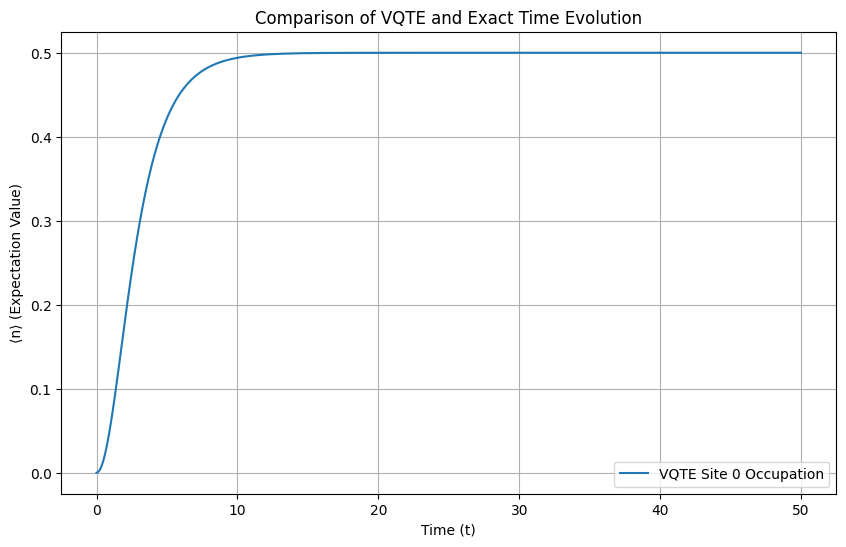

0.49999999999259204


In [3]:
main()